# Parsing and Recombining Inputs

In the chapter on [Grammars](Grammars.ipynb), we discussed how grammars can be
used to represent various languages. We also saw how grammars can be used to
generate strings of the corresponding language. Grammars can also perform the
reverse. That is, given a string, one can decompose the string into its
constituent parts that correspond to the parts grammar used to generate it
-- the derivation tree of that string. These parts (and parts from other similar
strings) can later be recombined using the same grammar to produce new strings.

In this chapter, we use grammars to parse and decompose inputs to
their corresponding derivation trees, allowing us to recombine them
arbitrarily.

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* An understanding of derivation trees from the [chapter on grammar fuzzer](GrammarFuzzer.ipynb)
  is also required.

In [1]:
import fuzzingbook_utils
from Grammars import EXPR_GRAMMAR, START_SYMBOL, RE_NONTERMINAL
from GrammarFuzzer import display_tree, all_terminals, GrammarFuzzer
from ExpectError import ExpectError

In order to parse a string, one needs to identify the language, and the
corresponding grammar. For example, here is a string that we would like to parse

In [2]:
mystring = '1+2'

This string is an arithmetic expression for addition, which may be specified using a grammar.

In [3]:
A1_GRAMMAR = {
   "<start>":
       ["<expr>"],
   "<expr>":
       ["<expr>+<expr>", "<expr>-<expr>", "<integer>"],
   "<integer>":
       ["<digit><integer>", "<digit>"],
   "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

The parse tree for our expression from this grammar is given by:

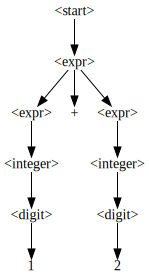

In [4]:
tree = ('<start>',[
    ('<expr>',[
        ('<expr>',[('<integer>',[('<digit>',[('1',[])])])]),
        ('+',[]),                           
        ('<expr>',[('<integer>',[('<digit>',[('2',[])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

While a grammar can be used to specify a given language, there could be multiple
grammars that correspond to the same language. For example, here is another 
grammar to describe the same addition expression.

In [5]:
A2_GRAMMAR = {
   "<start>":
      ["<expr>"],
   "<expr>":
      ["<integer><expr_>"],
   "<expr_>":
      ["+<expr>", "-<expr>", ""],
   "<integer>":
      ["<digit><integer_>"],
   "<integer_>":
      ["<integer>", ""],
   "<digit>":
      ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

The corresponding derivation tree is given by:

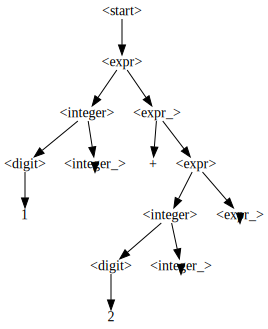

In [6]:
tree = ('<start>', [
    ('<expr>', [('<integer>',
                 [('<digit>', [('1', [])]), ('<integer_>', [('',[])])]),
                ('<expr_>', [('+', []), 
                             ('<expr>', [
                                 ('<integer>', [
                                     ('<digit>', [('2', [])]),
                                     ('<integer_>', [('',[])])]),
                                 ('<expr_>', [('',[])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

Indeed, there could be different classes of grammars that
describe the same language. For example, the first grammar `A1_GRAMMAR`
is a grammar that sports both _right_ and _left_ recursion, while the
second grammar `A2_GRAMMAR` does not have left recursion in the
non-terminals in any of its productions, but contains _epsilon_ productions.
(An epsilon production is a production that has empty string in its right
hand side.)

A grammar is left recursive if any of its non-terminals are left recursive,
and a non-terminal is directly left-recursive if the left-most symbol of
any of its productions is itself. It is indirectly left-recursive if any
of the left-most symbols can be expanded using their definitions to
produce the non-terminal as the left-most symbol of the expansion.
Right recursive grammars are defined similarly.

For example, in `A1_GRAMMAR`, the definition of `<expr>` is
left-recursive, and right recursive directly. However in `A2_GRAMMAR`,
`<expr>` is right recursive indirectly through the expansion of `<expr_>`.

To complicate matters further, there could be
multiple derivation trees -- also called _parses_ -- corresponding to the
same string from the same grammar. For example, a string `1+2+3` can be parsed
in two ways as we see below using the `A1_GRAMMAR`

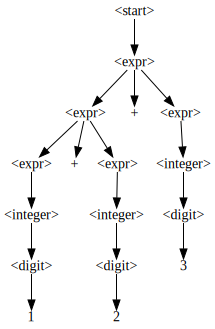

In [7]:
mystring = '1+2+3'
tree = ('<start>', [
    ('<expr>', [
        ('<expr>', [
            ('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
            ('+', []),
            ('<expr>', [('<integer>', [('<digit>', [('2', [])])])])]), 
        ('+', []), 
        ('<expr>', [('<integer>', [('<digit>', [('3', [])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

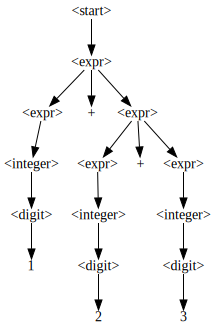

In [8]:
tree = ('<start>', [
    ('<expr>', [
        ('<expr>', [('<integer>', [('<digit>', [('1', [])])])]), 
        ('+', []), 
        ('<expr>', [
            ('<expr>', [('<integer>', [('<digit>', [('2', [])])])]), 
            ('+', []), 
            ('<expr>', [('<integer>', [('<digit>', [('3', [])])])])]) ])])
assert all_terminals(tree) == mystring
display_tree(tree)

Numerous parsing techniques exist that can take a grammar and the given
string, and produce the corresponding derivation tree or trees. However,
some of these techniques work only on specific classes of grammars.
These classes of grammars are named after the specific kind of parser
that can accept grammars of that category. That is, the upper bound for
the capabilities of the parser defines the grammar class named after that
parser.

Different classes of grammars differ in the features that are available to
the user for writing a grammar of that class. That is, the corresponding
kind of parser will be unable to parse a grammar that makes use of more
features than is allowed. For example, the `A2_GRAMMAR` is an _LL(1)_
grammar because it lacks left recursion, while `A1_GRAMMAR` is not an
_LL(1)_ grammar. This is because an _LL_ parser is a parser that parses
its input from left to right, and constructs a leftmost derivation of its
input by expanding the non-terminals it encounters. If there is a left
recursion in one of these rules, an _LL_ parser will enter an infinite loop.

We will examine a few classes of parsers next. First we define a few common
features required by all parsers we implement.

In [9]:
from functools import reduce, lru_cache
import re

The  `EXPR_GRAMMAR` we import from the [chapter on grammars](Grammars.ipynb) is oriented towards generation. In particular, the production rules are stored as strings. We need to massage this representation a little to conform to a canonical representation where each token in a rule is represented separately.

In [10]:
def split(rule):
    return [token
            for token in re.split(RE_NONTERMINAL, rule)
            if token]

def canonical(grammar):
    return  {key: [split(choice) for choice in choices]
             for key, choices in grammar.items()}

In [11]:
canonical(EXPR_GRAMMAR)

{'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

Next, we define a minimal interface for parsing, that is obeyed by all parsers.

In [12]:
class Parser(object):
    def __init__(self, grammar, start_symbol=START_SYMBOL):
        self.start_symbol = start_symbol
        self.grammar = grammar
        
    def parse_prefix(self, text):
        """Return pair (cursor, forest) for longest prefix of text"""
        raise NotImplemented()
        
    def parse(self, text):
        cursor, forest = self.parse_prefix(text)
        if cursor < len(text):
            raise SyntaxError("at " + repr(text[cursor:]))
        return forest

## Parsing Expression Grammars

Short of hand rolling a parser, _Packrat_ parsing is one of the simplest parsing techniques, and the class of grammar it accepts is called a _Parsing Expression Grammar_ (_Packrat_ is one of the techniques for parsing PEGs).

A _Parsing Expression Grammar_ comes is very similar to a _Context Free Grammar_. As in a _Context Free Grammar_, the grammar is represented by a set of non-terminals and corresponding **choice expressions** representing how to match each. For example, here is a PEG that matches `a` or `b`.

In [13]:
PEG1 = {
    '<start>': [['a'],['b']]
}

However, unlike the _CFG_, the choice expression is an **ordered choice**. That is, rather than choosing all rules that can potentially match, we stop at the first match that succeed. For example, the below _PEG_ can match `ab` but not `abc` unlike a _CFG_ which will match both.

In [14]:
PEG2 = {
    '<start>': [['ab'],['abc']]
}

Each choice in a _choice expression_ represents a rule on how to satisfy that particular choice. The choice is a sequence of tokens (terminals and non-terminals) that are matched against a given text as in a _CFG_.

Beyond the syntax of grammar definitions we have seen so far, a _PEG_ can can also contain a few additional elements. See the exercises at the end of the chapter for additional information.

The parsing expression grammars model the typical practice in handwritten recursive descent parsers, and hence it may be considered more intuitive to understand. Further, it comes with attractive properties such as linear time parsing (the time required to parse increases linearly with the increase in input length).

We look at the implementation of a simple PEG parser next.

### Packrat Parser for _PEGs_

The _Packrat_ parser  is so named because it tries to cache all results from simpler problems in the hope that these solutions can be used to avoid recomputation later.

#### The Parser
We derive from the `Parser` base class first, and we accept the text to be parsed in the `parse` method, which in turn calls `unify_key` with the `start_symbol` which is the starting point of parsing.

In [15]:
class PEGParser(Parser):
    def __init__(self, grammar, start_symbol):
        super().__init__(grammar, start_symbol)
        
    def parse_prefix(self, text):
        return self.unify_key(self.start_symbol, text, 0)

##### Unify Key
The `unify_key` algorithm is simple. If given a terminal symbol, it tries to match the symbol with the current position in the text. If the symbol and text match, it returns successfully with the new parse index `at`.

If on the other hand, it was given a non-terminal, it retrieves the choice expression corresponding to the key, and tries to match each choice in order using `unify_rule`. If **any** of the rules succeed in being unified with the given text, the parse is considered a success, and we return with the new parse index returned by `unify_rule`.

In [16]:
class PEGParser(PEGParser):
    def unify_key(self, key, text, at=0):
        if key not in self.grammar:
            if text[at:].startswith(key): return at + len(key), (key, [])
            else: return at, None
        for rule in self.grammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res: return (to, (key, res))
        return 0, None

##### Unify Rule

The `unify_rule` is similar. It retrieves the tokens corresponding to the rule that it needs to unify with the text, and calls `unify_key` on them in sequence. If **all** tokens are successfully unified with the text, the parse is a success.

In [17]:
class PEGParser(PEGParser):
    def unify_rule(self, rule, text, at):
        results = []
        for token in rule:
            at, res = self.unify_key(token, text, at)
            if res is None: return at, None
            results.append(res)
        return at, results

The two methods are mutually recursive, and given that `unify_key` tries each alternative until it succeeds, `unify_key` can be called multiple times with the same arguments. Hence, it is import to memoize the results of `unify_key`. Python provides a simple decorator that is available at `functools.lru_cache` for memoizing any function call that has hashable arguments. We add that to our implementation so that repeated calls to `unify_key` with same arguments get cached results.

This memoization gives the algorithm its name -- _Packrat_.

In [18]:
class PEGParser(PEGParser):
    @lru_cache(maxsize=None)
    def unify_key(self, key, text, at=0):
        if key not in self.grammar:
            if text[at:].startswith(key): return at + len(key), (key, [])
            else: return at, None
        for rule in self.grammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res: return (to, (key, res))
        return 0, None

We wrap initialization and calling of `PEGParser` in a method `parse` that accepts the text to be parsed along with the grammar.

In [19]:
def parse(text, grammar):
    peg = PEGParser(canonical(grammar), START_SYMBOL)
    return peg.parse(text)  

Here are a few examples of our parser in action.

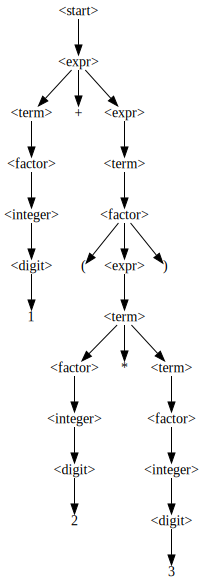

In [20]:
mystring = "1 + (2 * 3)"
tree = parse(mystring, EXPR_GRAMMAR)
assert all_terminals(tree) == mystring
display_tree(tree)

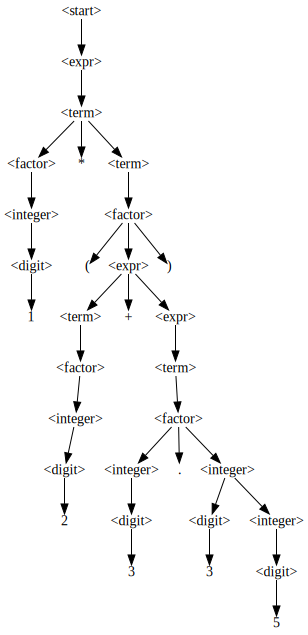

In [21]:
mystring = "1 * (2 + 3.35)"
tree = parse(mystring, EXPR_GRAMMAR)
assert all_terminals(tree) == mystring
display_tree(tree)

One should be aware that while the grammar looks like a _Context Free Grammar_, the language described by a PEG may be different (only _LL(1)_ grammars are guaranteed to represent the same language for both PEGs and other parsers), while other behaviors could be surprising~\cite{redziejowski2008}. 

While _Parsing Expression Grammars_ are simple at first sight, their behavior in some cases might be a bit unintuitive. For example, here is an example from Redziejowski~\cite{redziejowski}

In [22]:
PEG_SURPRISE = {
    "<A>": ["a<A>a","aa"]
}

When interpreted as a context free grammar and used as a string generator, it will produce strings of the form `a, aa, aaaa, aaaaaa` that is, it produces strings where the number of `a` is \Latex{2*n}.

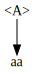

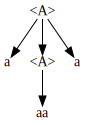

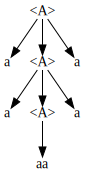

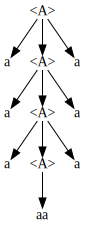

['aa', 'aaaa', 'aaaaaa', 'aaaaaaaa']

In [23]:
strings = []
for e in range(4):
    f = GrammarFuzzer(PEG_SURPRISE, '<A>')
    tree = ('<A>',None)
    for _ in range(e):
        tree = f.expand_tree_once(tree)
    tree = f.expand_tree_with_strategy(tree, f.expand_node_min_cost)
    strings.append(all_terminals(tree))
    display_tree(tree)
strings

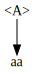

aa


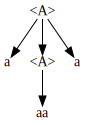

aaaa


Traceback (most recent call last):
  File "<ipython-input-24-ca40e06f7699>", line 4, in <module>
    tree = peg.parse(s)
  File "<ipython-input-12-ab6c0003a2e2>", line 13, in parse
    raise SyntaxError("at " + repr(text[cursor:]))
  File "<string>", line None
SyntaxError: at 'aa' (expected)


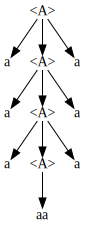

aaaaaaaa


In [24]:
peg = PEGParser(canonical(PEG_SURPRISE), '<A>')
for s in strings:
    with ExpectError():
        tree = peg.parse(s)
        display_tree(tree)
        print(s)

## Context Free Grammars

While the _Parsing Expression Grammars_ are expressive and the _packrat_ parser for parsing them is simple and intuitive, PEGs suffer from a major deficiency for our purposes. PEGs are oriented towards language recognition, and it is not clear how to translate an arbitrary PEG to a _CFG_. As we mentioned earlier, a naive re-interpretation of a PEG as a CFG does not work very well. Further, it is not clear what is the exact relation between the class of languages represented by _PEG_ and the the class of languages represented by _CFG_. Since our primary focus is _fuzzing_ -- that is _generation_ of strings, we next look at parsers that can accept _CFG_.

The `rules` method takes in a grammar and returns `(key,production)` pairs for each production in the grammar. This is an alternative representation of a grammar.

In [25]:
def rules(grammar):
    return [(key, choice)
            for key, choices in grammar.items()
            for choice in choices]

In [26]:
rules(canonical(EXPR_GRAMMAR))

[('<start>', ['<expr>']),
 ('<expr>', ['<term>', ' + ', '<expr>']),
 ('<expr>', ['<term>', ' - ', '<expr>']),
 ('<expr>', ['<term>']),
 ('<term>', ['<factor>', ' * ', '<term>']),
 ('<term>', ['<factor>', ' / ', '<term>']),
 ('<term>', ['<factor>']),
 ('<factor>', ['+', '<factor>']),
 ('<factor>', ['-', '<factor>']),
 ('<factor>', ['(', '<expr>', ')']),
 ('<factor>', ['<integer>', '.', '<integer>']),
 ('<factor>', ['<integer>']),
 ('<integer>', ['<digit>', '<integer>']),
 ('<integer>', ['<digit>']),
 ('<digit>', ['0']),
 ('<digit>', ['1']),
 ('<digit>', ['2']),
 ('<digit>', ['3']),
 ('<digit>', ['4']),
 ('<digit>', ['5']),
 ('<digit>', ['6']),
 ('<digit>', ['7']),
 ('<digit>', ['8']),
 ('<digit>', ['9'])]

The `terminals` method extracts all terminal symbols from a `canonical` grammar representation.

In [27]:
def terminals(grammar):
    return set(token
               for key, choice in rules(grammar)
               for token in choice if token not in grammar)

In [28]:
terminals(canonical(EXPR_GRAMMAR))

{' * ',
 ' + ',
 ' - ',
 ' / ',
 '(',
 ')',
 '+',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9'}

We require an additional method to massage our `EXPR_GRAMMAR`. This method removes the extraneous spaces from the grammar definition. While the spaces are reasonable when one is generating strings, they make our parses needlessly complicated.

In [29]:
def shrink(rule):
    return [i.strip() for i in rule]

def canonical(grammar):
    return  {k: [shrink(split(l)) for l in rules]
             for k, rules in grammar.items()}

In [30]:
canonical(EXPR_GRAMMAR)

{'<start>': [['<expr>']],
 '<expr>': [['<term>', '+', '<expr>'], ['<term>', '-', '<expr>'], ['<term>']],
 '<term>': [['<factor>', '*', '<term>'],
  ['<factor>', '/', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

### Nearley Parser

The Earley parser is a general parser that is able to parse arbitrary _Context Free Grammars_. It was invented by Jay Earley~\cite{Earley1970} for use in computational linguistics. While its computational complexity is $O(n^3)$ for arbitrary grammars, it can parse unambiguous grammars in $O(n^2)$ time, and all _[LR(k)](https://en.wikipedia.org/wiki/LR_parser)_ grammars in linear time ($O(n)$~\cite{Leo1991}). Further improvements -- notably handling epsilon rules -- were invented by Aycock et al.~\cite{Aycock2002}.

Note that one restriction of our implementation is that the start symbol should have only one choice in its choice expression. This is not a restriction in practice because any grammar with multiple choices in its start symbol can be extended with a new start symbol that has the original start symbol as its only choice. That is, given a grammar as below to conform to the single choice rule:

```
grammar = {
    '<start>': [['<A>'], ['<B>']],
    '<A>': [['a']],
    '<B>': [['b']],    
}
```
One may rewrite it as
```
grammar = {
    '<start>': [['<start_>']],
    '<start_>': [['<A>'], ['<B>']],
    '<A>': [['a']],
    '<B>': [['b']],    
}
```

Secondly, while a full implementation of Earley parser can deal with arbitrary _Context Free Grammars_, the implementation, especially that of retrieving the derivation trees is complex. Hence, we have opted for a simpler variation that sacrifices some performance for simplicity. Our simpler implementation also requires that the grammar **does not contain rules that derive the empty string**.

The parser uses dynamic programming to generate a table containing a forest of possible parses at each letter index -- the table contains as many columns as there are letters in the input, and each column contains different parsing rules at various stages of the parse.


#### Columns
We define the `Column` first. The `Column` is initialized by its own `index` in the input string, and the `letter` at that index. Internally, we also keep track of the states that are added to the column as the parsing progresses.

In [31]:
class Column(object):
    def __init__(self, index, letter):
        self.index, self.letter = index, letter
        self.states, self._unique =  [], {}

The `Column` only stores unique `states`. Hence, when a new `state` is `added` to our `Column`, we check whether it is already known.

In [32]:
class Column(Column):
    def add(self, state):
        if state in self._unique: return self._unique[state]
        self._unique[state] = state
        self.states.append(state)
        state.e_col = self
        return self._unique[state]

#### States

A `State` represents a parse in progress for a specific rule corresponding to a non-terminal. Hence, the state contains the `name` of the non-terminal, the corresponding choice expression (`expr`), and the current position of parsing in this expression (`dot`). We further store the starting column `s_col` and ending column `e_col` for each. Finally, we store a references to all the child states (that is, all states that originates from non-terminals in the `expr`). Since we are interested in comparing states, we define `hash` and `eq` with the corresponding methods.

Note that our hash and equality operators include comparison with `<state>.children`. This means that we store more states per column than strictly necessary by the canonical Earley algorithm -- The canonical Earley algorithm only stores states that differ by `name`, `expr` and `dot`. However, these also make retrieving the parse tree simpler as we will demonstrate later.

**Note** If you are familiar with [LR parsing](https://en.wikipedia.org/wiki/LR_parser), you will notice that a state is simply an `LR0` item along meta information such as start and end columns, and children.

In [33]:
class State(object):
    def __init__(self, name, expr, dot, s_col, children=[]):
        self.name, self.expr, self.dot = name, expr, dot
        self.s_col, self.e_col = s_col, None
        self.children = children[:]
        
    def _t(self):
        return (self.name, self.expr, self.dot, self.s_col.index, tuple(self.children))
    def __hash__(self):
        return hash(self._t())
    def __eq__(self, other):
        return  self._t() == other._t()

We also provide a few convenience methods. The method `finished` checks if the `dot` has moved beyond the last element in `expr`. The method `advance` produces a new `State` with the `dot` advanced one token, and represents an advance of the parse state. and `at_dot` returns the current symbol being parsed.

In [34]:
class State(State):
    def finished(self):
        return self.dot >= len(self.expr)
    def advance(self):
        return State(self.name, self.expr, self.dot+1, self.s_col, self.children)
    def at_dot(self):
        return self.expr[self.dot] if self.dot < len(self.expr) else None

#### The Parser

We use the following grammar in our examples below.
```
grammar = {
    '<start>': [['<A>','<B>']],
    '<A>': [['a','<B>','c'], ['A','<A>']],
    '<B>': [['b','<C>'], ['<D>']],
    '<C>': [['c']],
    '<D>': [['d']]
}
```

The _Earley_ algorithm starts by initializing the chart with columns (as many as there are letters in the input). We also seed the first column with a state representing the choice expression corresponding to the start symbol. In our case, the state corresponds to the start symbol with the `dot` at `0` is represented as below. The `|` symbol represents the paring status. In this case, we have not parsed anything.

```
<start>: | <A> <B>
```
We pass this partial chart to a method for filling the rest of the parse chart.

We call it the `NearlyParser` because it is not yet an `Earley` parser.

In [35]:
class NearleyParser(Parser):
    def chart_parse(self, words, start):
        alt = tuple(*self.grammar[start])
        chart = [Column(i, tok) for i,tok in enumerate([None, *words])]
        chart[0].add(State(start, alt, 0, chart[0]))
        return self.fill_chart(chart)

The main loop has three fundamental operations. We have seeded the chart with the state representing parse of the start symbol. The choice expression corresponding to the start symbol may be as follows:

##### Predict
We have already seeded `chart[0]` with a state `[<A>,<B>]` with `dot` at `0`. Next, given that `<A>` is a non-terminal, we `predict` the possible parse continuations of this state. That is, it could be either `a <B> c` or `A <A>`.

The general idea of `predict` is as follows: Say you have a state with name `<A>` from the above grammar, and expression containing `[a,<B>,c]`. Imagine that you are have seen `a` already, which means that the `dot` will be on `<B>`. Below, is a representation of our parse status. The left hand side of `|` represents the portion already parsed (`a`), and the right hand side represents the portion yet to be parsed (`<B> c`).

```
<A>: a | <B> c
```

To recognize `<B>`, we look at the definition of `<B>`, which has different alternative choices. The `predict` step adds each of these choices to the set of states, with `dot` at `0`.

```
<A>: a | <B> c
<B>: | b c
<B>: | <D>
```

In essence, the `predict` method, when called with the current non-terminal, fetches the choices expressions corresponding to this non-terminal, and adds these as predicted _child_ states to the _current_ column.

In [36]:
class NearleyParser(NearleyParser):
    def predict(self, col, sym):
        for alt in self.grammar[sym]:
            col.add(State(sym, tuple(alt), 0, col))

##### Scan
What if rather than a non-terminal, the state contained a terminal symbol -- i.e a letter? In that case, we are ready to make some progress. For example, consider the second state above
```
<B>: | b c
```
We `scan` the next column's letter. Say the next token is `b`.
If the letter matches what we have, then create a new state by advancing the current state by one letter.

```
<B>: b | c
```
This new state is added to the next column (i.e the column that has the matched letter).

In [37]:
class NearleyParser(NearleyParser):
    def scan(self, col, state, letter):
        if letter == col.letter:
            col.add(state.advance())

##### Complete

When we advance, what if we actually `complete` the processing of the current rule? If so, we want to update not just this state, but also all the _parent_ states from which this state was derived.
For example, say we have states as below.
```
<A>: a | <B> c
<B>: b c |
```
The state `<B>: b c |` is now complete. So, we need to advance `<A>: a | <B> c` one step forward.

How do we determine the parent states? Note from `predict` that we added the predicted child states to the _same_ column as that of the inspected state. Hence, we look at the starting column of the current state, with the same symbol `at_dot` as that of the name of the completed state.

For each such parent found, we advance that parent (because we have just finished parsing that non terminal for their `at_dot`) and add the new states to the current column. We also mark the current state as a child state for the advanced parent state.

In [38]:
class NearleyParser(NearleyParser):
    def complete(self, col, state): return self.nearley_complete(col, state)
    def nearley_complete(self, col, state):
        parent_states = [st for st in state.s_col.states
                     if st.at_dot() == state.name]
        for st in parent_states:
            col.add(st.advance()).children.append(state)

##### Fill chart
The main driving loop in `fill_chart` essentially calls these operations in order. We loop over each column in order. For each column, fetch one state in the column at a time, and check if the state is `finished`. If it is, then we `complete` all the parent states depending on this state. If the state was not finished, we check to see if the state's current symbol `at_dot` is a non-terminal. If it is a non-terminal, we `predict` possible continuations, and update the current column with these states. If it was not, we `scan` the next column and advance the current state if it matches the next letter.

**Advanced:** While our implementation (and the original implementation of the algorithm by Jay Earley) does not handle rules that can derive empty strings (these are called _epsilon rules_). Aycock et al. provides a simple solution for handling epsilon rules. If one is of the symbols during the `predict` step is is a a `nullable` non-terminal -- that is, it can derive an empty string, then after the `predict` step advance the current `state`, and add it to the current column -- i.e `col.add(state.shift())`. One also would need to add the child states to the advanced state. We do not implement this here.

In [39]:
class NearleyParser(NearleyParser):
    def fill_chart(self, chart):
        for i, col in enumerate(chart):
            for state in col.states:
                if state.finished():
                    self.complete(col, state)
                else:
                    sym = state.at_dot()
                    if sym in self.grammar:
                        self.predict(col, sym)
                    else:
                        if i + 1 >= len(chart): continue
                        self.scan(chart[i+1], state, sym)
        return chart


Since `chart_parse` returns the completed table, we now need to extract the derivation trees. Fortunately, this is simple given that we have kept the list of children for each state. All that we need to do is to fetch the finished states corresponding to the `start_symbol`, and retrieve the derivation trees for each child.

##### Parse

In [40]:
class NearleyParser(NearleyParser):
    def parse_prefix(self, text):
        table = self.chart_parse(text, self.start_symbol)
        for col in reversed(table):
            states = [st for st in col.states if st.name == self.start_symbol]
            if states: return col.index, states
        return -1, []

    def parse(self, text):
        cursor, states = self.parse_prefix(text)
        if cursor != len(text): return []
        for state in states:
            if state.finished():
                yield self.derivation_tree(state)

    def process_expr(self, expr, children):
        terms = iter([(i,[]) for i in expr if i not in self.grammar])
        nts = iter([self.derivation_tree(i) for i in  children])
        return [next(terms if i not in self.grammar else nts) for i in expr]

    def derivation_tree(self, state):
        return (state.name, self.process_expr(state.expr, state.children))

In [41]:
def parse(text, grammar, start=START_SYMBOL):
    ep = NearleyParser(grammar, start)
    return ep.parse(text)  

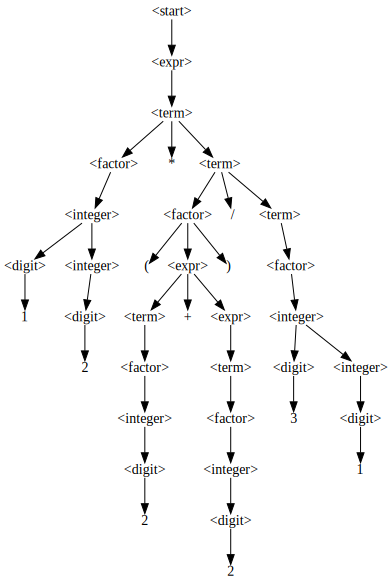

In [42]:
new_grammar = canonical(EXPR_GRAMMAR)
mystring = '12*(2+2)/31'
for tree in parse(list(mystring), new_grammar):
    assert mystring == all_terminals(tree)
    display_tree(tree)

#### Ambiguous parsing

Ambiguous grammars are grammars that can produce multiple derivation trees for some given string. For example, the grammar below can parse `1+2+3` in two different ways -- `[1+2]+3` and `1+[2+3]`. Both the parse trees can be retrieved using the `Earley` parser. 

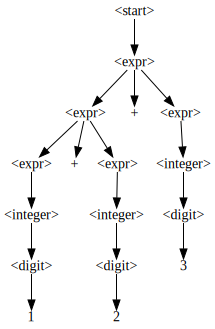

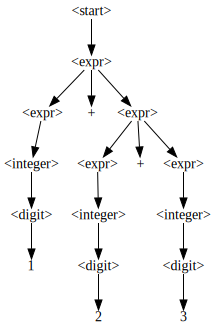

In [43]:
new_grammar = canonical(A1_GRAMMAR)
mystring = '1+2+3'
for tree in parse(list(mystring), new_grammar, '<start>'):
    assert mystring == all_terminals(tree)
    display_tree(tree)

### Earley Parser

We mentioned previously that our implementation took certain liberties with how states are stored in the `NearleyParser`. We pay for that in the performance penalty incurred. What if we do not want to pay that penalty? We next modify our parser so that it is a true Earley parser.

#### States
The first modification is how states are compared. We no longer want to distinguish states with different children. Instead, we will obtain a parse forest at the end of the parse, from which derivation trees can be obtained.

In [44]:
class State(State):
    def __init__(self, name, expr, dot, s_col):
        self.name, self.expr, self.dot = name, expr, dot
        self.s_col, self.e_col = s_col, None

    def _t(self):
        return (self.name, self.expr, self.dot, self.s_col.index)
    
    def advance(self):
        return State(self.name, self.expr, self.dot+1, self.s_col)

#### The Parser

Similarly, we no longer track the children during `complete`.
##### Complete

In [45]:
class EarleyParser(NearleyParser):
    def complete(self, col, state): return self.earley_complete(col, state)
    def earley_complete(self, col, state):
        parent_states = [st for st in state.s_col.states
                     if st.at_dot() == state.name]
        for st in parent_states:
            col.add(st.advance())

##### Parse

The following is adapted from the excellent reference on Earley parsing by [Loup Vaillant](http://loup-vaillant.fr/tutorials/earley-parsing/).

The new `parse` procedure has to construct the parsed forest. Our original chart is a table of states that contains production rules that end at that index. For easier parsing, we switch to a table that contains rules that begins at that index.

In [46]:
class EarleyParser(EarleyParser):
    def reverse(self, table):
        f_table = [Column(c.index, c.letter) for c in table]
        for col in table:
            finished = [s for s in col.states if s.finished()]
            for s in finished:
                f_table[s.s_col.index].states.append(s)
        return f_table

In the interest of simplicity, we do not attempt to return all possible derivation trees from `parse`. Rather, we return the first available derivation tree. To do that, we need to extract the parse forest from the state corresponding to `start`.

In [47]:
class EarleyParser(EarleyParser):
    def extract_trees(self, forest):
        return [self.extract_a_tree(forest)]
    
    def parse(self, text):
        cursor, states = self.parse_prefix(text)
        if cursor != len(text): return []
        table = self.chart_parse(text, self.start_symbol)
        f_table = self.reverse(table)
        start = next(s for s in states if s.finished())
        return self.extract_trees(self.parse_forest(f_table, start))

##### Parse Forests

The `parse_forest` takes the state which represents the completed parse, and determines the possible ways that its expressions corresponded to the parsed expression. For example, say we are parsing `1+2+3`, and the state has `[<expr>,+,<expr>]` in `expr`. It could have been parsed either `[{<expr>:1+2},+,{<expr>:3}]` or `[{<expr>:1},+,{<expr>:2+3}]`.

In [48]:
class EarleyParser(EarleyParser):
    def parse_forest(self, chart, state):
        if not state.expr: return (state.name, [])
        pathexprs = self.parse_paths(state.expr, chart, state.s_col.index, state.e_col.index)
        paths_ = []
        for pathexpr in pathexprs:
            pathexpr_ = []
            for varexpr in pathexpr:
                completion = (self.parse_forest(chart, varexpr)
                              if isinstance(varexpr, State)
                              else (varexpr, []))
                pathexpr_.append(completion)
            paths_.append(pathexpr_)
        return (state.name, paths_)

##### Parse Paths

The parse paths tries to unify the given expression in `expr_` with the parsed string. For that, it extracts the first symbol in `expr_` and checks if it is a terminal symbol. If it is, then it checks the chart to see if the letter corresponding to the position matches the terminal symbol. If it does, advance our start index by the length of the symbol.

If the symbol was a non-terminal symbol, then we retrieve the parsed states at the current start index that correspond to the non-terminal symbol, and collect the end index. These are the start indexes for the remaining expression.

Given our list of start index, we obtain the parse paths from the remaining expression. If we can obtain any, then we return the parse paths. If not, we had an error. We return `None` in that case.

In [49]:
class EarleyParser(EarleyParser):
    def parse_paths(self, expr_, chart, frm, til):
        var,*expr = expr_
        starts = None
        if var not in self.grammar:
            starts = ([(var, frm + len(var))] if
                      frm<til and chart[frm+1].letter == var else [])
        else:
            starts = [(s, s.e_col.index)
                      for s in chart[frm].states if s.name == var]

        paths = []
        for state,start in starts:
            if not expr:
                paths.extend([[state]] if start == til else [])
            else:
                res = self.parse_paths(expr, chart, start, til)
                paths.extend([[state] + r for r in res])
        return paths

##### extract_a_tree

What we have from `parse_forest` is a forest of trees. We need to extract a single tree from that forest. That is accomplished as follows. (We adapt the solution given by [Loup Vaillant](http://loup-vaillant.fr/tutorials/earley-parsing/parser))

In [50]:
class EarleyParser(EarleyParser):
    def extract_a_tree(self, forest_node):
        name, paths = forest_node
        if not paths: return (name, [])
        return (name, [self.extract_a_tree(p) for p in paths[0]])

We now verify that our modifications work.

In [51]:
A3_GRAMMAR = {
        "<start>":
        ["<expr>"],
        "<expr>":
        ["<expr>+<expr>", "<expr>-<expr>","(<expr>)", "<integer>"],
        "<integer>":
        ["<digit><integer>", "<digit>"],
        "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
        }

In [52]:
def parse(text, grammar, start=START_SYMBOL):
    ep = EarleyParser(canonical(grammar), start)
    return ep.parse(text)  

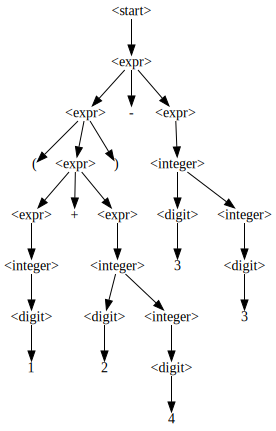

In [53]:
mystring = '(1+24)-33'
tree = parse(mystring, A3_GRAMMAR)[0]
assert all_terminals(tree) == mystring
display_tree(tree)

##### extract_trees

Extracting a single tree might be reasonable for unambiguous parses. However, what if the given grammar produces amgiguity when given a string? We need to extract all derivation trees in that case. We enhance our `extract_trees` to extract multiple derivation trees.

In [54]:
class EarleyParser(EarleyParser):
    def extract_trees(self, forest_node):
        name, paths = forest_node
        if not paths: return [(name, [])]
        results = []
        for path in paths:
            ptrees = zip(*[self.extract_trees(p) for p in path])
            results.extend([(name, p) for p in ptrees])
        return results

As before, we verify that everything works.

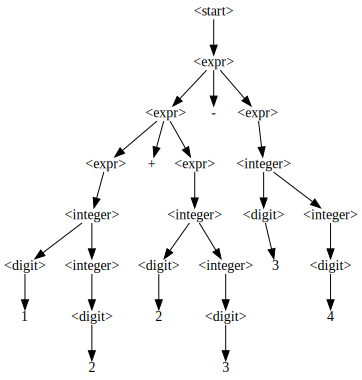

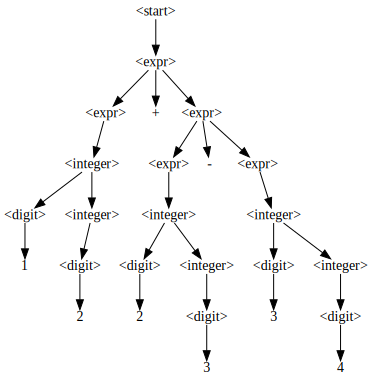

In [55]:
mystring = '12+23-34'
for tree in parse(mystring, A1_GRAMMAR):
    assert mystring == all_terminals(tree)
    display_tree(tree)

#### The Aycock Epsilon fix

While parsing, one often requires to know whether a given non-terminal can derive an empty string. For example, in the following grammar A can derive an empty string, while B can not. The non-terminals that can derive an empty string is called a nullable non-terminal.

In [56]:
my_grammar = {
    '<start>': [['<A>'], ['<B>']],
    '<A>': [['a'],['']],
    '<B>': [['b']]
}

One of the problems with the original Earley implementation is that it does not handle rules that can derive empty strings very well. For example, the given grammar should match `a`

In [57]:
EPSILON = ''
E_GRAMMAR = {
        '<start>': ['<S>'],
        '<S>': ['<A><A><A><A>'],
        '<A>': ['a', '<E>'],
        '<E>': [EPSILON]
}

In [58]:
mystring = 'a'
tree = parse(mystring, E_GRAMMAR)
print(tree)

[]


Aycock et al. suggests a simple fix. Their idea is to pre-compute the `nullable` set and use it to advance the `nullable` states. However, before we do that, we need to compute the `nullable` set. The `nullable` set consists of all non-terminals that can derive an empty string.

Computing the `nullable` set requires expanding each production rule in the grammar iteratively and inspecting whether a given rule can derive the empty string. Each iteration needs to take into account new terminals that have been found to be `nullable`. The procedure stops when we obtain a stable result. This procedure can be abstracted into a more general method `fixpoint`.

##### Fixpoint

A `fixpoint` of a function is an element in the function's domain such that it is mapped to itself. For example, 1 is a `fixpoint` of square root because `squareroot(1) == 1`.

(We use `str` rather than `hash` to check for equality in `fixpoint` because the data structure `set`, which we would like to use as an argument has a good string representation but is not hashable).

In [59]:
def fixpoint(f):
    def helper(arg):
        while True:
            sarg = str(arg)
            arg_ = f(arg)
            if str(arg_) == sarg:
                return arg
            arg = arg_
    return helper

Remember `my_sqrt` from the first chapter? We can define my_sqrt using fixpoint.

In [60]:
def my_sqrt(x):
    @fixpoint
    def _my_sqrt(approx):
        return (approx + x / approx) / 2
    return _my_sqrt(1)

In [61]:
my_sqrt(2)

1.414213562373095

##### Nullable

Similarly, we can define `nullable` using `fixpoint`. We essentially provide the definition of a single intermediate step. That is, assuming that `nullables` contain the current `nullable` non-terminals, we iterate over the grammar looking for productions which are `nullable` -- that is, productions where the entire sequence can yield an empty string on some expansion.

In [62]:
def nullable_expr(expr, nullables): return all(token in nullables for token in expr)

def nullable(grammar):
    productions = rules(grammar)
    @fixpoint
    def nullable_(nullables):
        for A, expr in productions:
            if nullable_expr(expr, nullables): nullables |= {A}
        return (nullables)
    return nullable_({EPSILON})

In [63]:
nullable(canonical(E_GRAMMAR))

{'', '<A>', '<E>', '<S>', '<start>'}

So, once we have the `nullable` set, all that we need to do is, after we have called `predict` on a state corresponding to a non-terminal, check if it is `nullable` and if it is, advance and add the state to the current column.

In [64]:
class EarleyParser(EarleyParser):
    def fill_chart(self, chart):
        epsilon = nullable(self.grammar)
        for i, col in enumerate(chart):
            for state in col.states:
                if state.finished():
                    self.complete(col, state)
                else:
                    sym = state.at_dot()
                    if sym in self.grammar:
                        self.predict(col, sym)
                        if sym in epsilon:
                            col.add(state.advance())
                    else:
                        if i + 1 >= len(chart): continue
                        self.scan(chart[i+1], state, sym)
        return chart


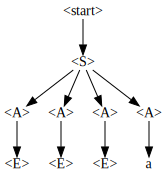

In [65]:
mystring = 'a'
tree = parse(mystring, E_GRAMMAR)[0]
display_tree(tree)

## Further Information
* Parsing with arbitrary context free grammars is reducible to boolean matrix multiplication~\cite{Valiant1975} (and the reverse~\cite{Lee2002}) which is at present bounded by \Latex{O(2^{23728639}}) ~\cite{LeGall2014}
* The actual class of languages that is expressible in PEG is currently unknown. In particular, we know that PEGs can express certain languages such as \Latex{a^n b^n c^n}. However, we do not know if there exist Context-Free languages that are not expressible with PEGs.

## Lessons Learned

* Grammars can be used to generate derivation trees for a given string.
* Parsing Expression Grammars are intuitive, and easy to implement, but require care to write.
* Earley Parsers can parse arbitrary Context Free Grammars.

## Next Steps

* [Use the automatic grammar miner for obtaining grammar](GrammarMiner.ipynb)
* [Mutate the strings using grammar]


## Exercises

### Exercise 1 _More PEG Syntax_

The _PEG_ syntax provides a few notational conveniences reminiscent of regular expressions. For example, it supports the following operators (letters `T` and `A` represents tokens that can be either terminal or non-terminal. `ε` is an empty string, and `/` is the ordered choice operator similar to the non-ordered choice operator `|`):

* `T?` represents an optional greedy match of T and `A := T?` is equivalent to `A := T/ε`.
* `T*` represents zero or more greedy matches of `T` and `A := T*` is equivalent to `A := T A/ε`.
* `T+` represents one or more greedy matches -- equivalent to `TT*`

If you look at the three notations above, each can be represented in the grammar in terms of basic syntax.
Remember the exercise from [the chapter on grammars](Grammars.ipynb) that developed `define_ex_grammar` that can represent grammars as Python code? extend `define_ex_grammar` to `define_peg` to support the above notational conveniences. The decorator should rewrite a given grammar that contain these notations to an equivalent grammar in basic syntax.

### Exercise 2 _PEG Predicates_

Beyond these notational conveniences, it also supports two predicates that can provide a powerful lookahead facility that does not consume any input.

* `T&A` represents an _And-predicate_ that matches `T` if `T` is matched, and it is immediately followed by `A`
* `T!A` represents a _Not-predicate_ that matches `T` if `T` is matched, and it is *not* immediately followed by `A`

Implement these predicates in our _PEG_ parser.

### Exercise 3 _Earley Fill Chart_

In the `Earley Parser`, `Column` class, we keep the states both as a `list` and also as a `dict` even though `dict` is ordered. Can you explain why?

**Hint**: see the `fill_chart` method.

### Exercise 4 _Leo Parser_

One of the problems with the original Earley parser is that while it can parse strings using arbitrary _Context Free Gramamrs_, its performance on right-recursive grammars is quadratic. That is, it takes $O(n^2)$ runtime and space for parsing with right-recursive grammars. For example, consider these grammars:

In [66]:
LR_GRAMMAR = {
        '<start>': ['<A>'],
        '<A>': ['<A>a', ''],
}

RR_GRAMMAR = {
        '<start>': ['<A>'],
        '<A>': ['a<A>', ''],
}

We enable logging to see the parse progress

In [67]:
class Column(Column):
    def __str__(self):
        return "%s chart[%d]\n%s" % (
            self.letter, self.index, "\n".join(str(state)
                for state in self.states if state.finished()))
class State(State):
    def __str__(self):
        return self.name +':= '+ ' '.join([str(p) for p in
                [*self.expr[:self.dot],'|', *self.expr[self.dot:]]]) + "(%d,%d)" % (self.s_col.index, self.e_col.index)

class LoggingParser(EarleyParser):
    def fill_chart(self, chart):
        epsilon = nullable(self.grammar)
        for i, col in enumerate(chart):
            for state in col.states:
                if state.finished():
                    self.complete(col, state)
                else:
                    sym = state.at_dot()
                    if sym in self.grammar:
                        self.predict(col, sym)
                        if sym in epsilon:
                            col.add(state.advance())
                    else:
                        if i + 1 >= len(chart): continue
                        self.scan(chart[i+1], state, sym)
            print(str(col),"\n")
        print('_'*80)
        return chart

In [68]:
result = LoggingParser(canonical(LR_GRAMMAR)).parse_prefix('aaaaaa')

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= <A> a |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= <A> a |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= <A> a |(0,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= <A> a |(0,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= <A> a |(0,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= <A> a |(0,6)
<start>:= <A> |(0,6) 

________________________________________________________________________________


In [69]:
result = LoggingParser(canonical(RR_GRAMMAR)).parse_prefix('aaaaaa')

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= |(1,1)
<A>:= a <A> |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= |(2,2)
<A>:= a <A> |(1,2)
<A>:= a <A> |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= |(3,3)
<A>:= a <A> |(2,3)
<A>:= a <A> |(1,3)
<A>:= a <A> |(0,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= |(4,4)
<A>:= a <A> |(3,4)
<A>:= a <A> |(2,4)
<A>:= a <A> |(1,4)
<A>:= a <A> |(0,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= |(5,5)
<A>:= a <A> |(4,5)
<A>:= a <A> |(3,5)
<A>:= a <A> |(2,5)
<A>:= a <A> |(1,5)
<A>:= a <A> |(0,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= |(6,6)
<A>:= a <A> |(5,6)
<A>:= a <A> |(4,6)
<A>:= a <A> |(3,6)
<A>:= a <A> |(2,6)
<A>:= a <A> |(1,6)
<A>:= a <A> |(0,6)
<start>:= <A> |(0,6) 

________________________________________________________________________________


As can be seen from the parsing log for each letter, the number of states with representation `<A>:= a <A> | (i, j)` increases at each stage, and these are simply a left over from the previous letter. They do not contribute anything more to the parse other than to simply complete these entries. However, they take up space, and require resources for inspection, contributing a factor of `n` in analysis.

Joop Leo~\cite{Leo1991} found that this inefficiency can be avoided by detecting right recursion. The idea is that before starting the `completion` step, check whether the current item has a _deterministic reduction path_. If such a path exists, add a copy of the topmost element of the _deteministic reduction path_ to the current column, and return. If not, perform the original `completion` step.

Finding a _deterministic reduction path_ is as follows:

Given a complete state, represented by `<A> := ... | (i)` where `(i)` is the starting column, there is a _deterministic reduction path_ above it if two criteria are satisfied.
* There exist an item `<B> := ... <A> | (k)` in the current column.
* It should have a _single_ predecessor of the form `<B> := ... | <A> (k)` in the current column.
Following this chain (looking for the link above `<B> := ... <A> | (k)`), the topmost item is the item that does not have a parent.

See [Loup Vaillant](http://loup-vaillant.fr/tutorials/earley-parsing/right-recursion) for further information.

In [70]:
class State(State):
    def __init__(self, name, expr, dot, s_col, tag=None):
        super().__init__(name, expr, dot, s_col)
        self.tag = tag

    def copy(self, tag=None):
        return State(self.name, self.expr, self.dot, self.s_col, tag)

class LeoParser(LoggingParser):
    def complete(self, col, state): return self.leo_complete(col, state)
    
    def leo_complete(self, col, state):
        detred = self.deterministic_reduction(state)
        if detred:
            col.add(detred.copy())
        else:
            self.earley_complete(col, state)


Can you implement the `deterministic_reduction` method to obtain the top most element?

In [71]:
def splitlst(predicate, iterable):
    return reduce(lambda res, e: res[predicate(e)].append(e)
                  or res, iterable, ([], []))

class LeoParser(LeoParser):
    def check_single_item(self, st, remain):
        res = [s for s in remain
                 if s.name == st.name and s.expr == st.expr and
                    s.s_col.index == st.s_col.index and s.dot == (st.dot - 1)]
        return len(res) == 1

    @lru_cache(maxsize=None)
    def get_above(self, state):
        remain, finished = splitlst(lambda s: s.finished(), state.s_col.states)
        res = [st for st in finished if len(st.expr) > 1 and state.name == st.expr[-1]]
        vals = [st for st in res if self.check_single_item(st, remain)]
        if vals:
            assert len(vals) == 1
            return vals[0]
        return None

    def deterministic_reduction(self, state):
        st = state
        while True:
            _st = self.get_above(st)
            if not _st: break
            st = _st
        return st if st != state else None
    
    def complete(self, col, state): return self.leo_complete(col, state)
    
    def leo_complete(self, col, state):
        detred = self.deterministic_reduction(state)
        if detred:
            col.add(detred.copy())
        else:
            self.earley_complete(col, state)


Now, both LR and RR grammars should work within $O(n)$ bounds.

In [72]:
result = LeoParser(canonical(RR_GRAMMAR)).parse_prefix('aaaaaa')

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= |(1,1)
<A>:= a <A> |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= |(2,2)
<A>:= a <A> |(1,2)
<A>:= a <A> |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= |(3,3)
<A>:= a <A> |(2,3)
<A>:= a <A> |(0,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= |(4,4)
<A>:= a <A> |(3,4)
<A>:= a <A> |(0,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= |(5,5)
<A>:= a <A> |(4,5)
<A>:= a <A> |(0,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= |(6,6)
<A>:= a <A> |(5,6)
<A>:= a <A> |(0,6)
<start>:= <A> |(0,6) 

________________________________________________________________________________


In [73]:
result = LeoParser(canonical(LR_GRAMMAR)).parse_prefix('aaaaaa')
result

None chart[0]
<A>:= |(0,0)
<start>:= <A> |(0,0) 

a chart[1]
<A>:= <A> a |(0,1)
<start>:= <A> |(0,1) 

a chart[2]
<A>:= <A> a |(0,2)
<start>:= <A> |(0,2) 

a chart[3]
<A>:= <A> a |(0,3)
<start>:= <A> |(0,3) 

a chart[4]
<A>:= <A> a |(0,4)
<start>:= <A> |(0,4) 

a chart[5]
<A>:= <A> a |(0,5)
<start>:= <A> |(0,5) 

a chart[6]
<A>:= <A> a |(0,6)
<start>:= <A> |(0,6) 

________________________________________________________________________________


(6, [<__main__.State at 0x10e220710>])

__Advanced:__ We have fixed the complexity bounds. However, because we are saving only the top most item of a right recursion, we need to fix our `parse_forest` and `extract_a_tree` to be aware of our fix. Can you fix both?

_Solution_: No solution given.

### Exercise 5 _First set of a non-terminal_

We previously gave a way to extract a the `nullable` (epsilon) set, which is often used for parsing.
Along with `nullable`, parsing algorithms often use two other sets [`first` and `follow`](https://en.wikipedia.org/wiki/Canonical_LR_parser#FIRST_and_FOLLOW_sets).
The first set of a terminal symbol is itself, and the first set of a non-terminal is composed of terminal symbols that can come at the beginning of any derivation
of that non-terminal. The first set of any non-terminal that can derive the empty string should contain `EPSILON`. For example, using our `A1_GRAMMAR`, the first set of both `<expr>` and `<start>` is `{0,1,2,3,4,5,6,7,8,9}`. The extraction first set for any self-recursive non-terminal is simple enough. One simply has to recursively compute the first set of the first element of its choice expressions. The computation of `first` set for a self-recursive non-terminal is tricky. One has to recursively compute the first set until one is sure that no more terminals can be added to the first set.

Can you implement the `first` set using our `fixpoint`?

The first set of all terminals is the set containing just themselves. So we initialize that first. Then we update the first set with rules that derive empty strings.

In [74]:
def firstset(grammar, nullable):
    first = {i:{i} for i in terminals(grammar)}
    for k in grammar:
        first[k] = {EPSILON} if k in nullable else set()
    return firstset_((rules(grammar), first, nullable))[1]

Finally, we rely on the `fixpoint` to update the first set with the contents of the current first set until the first set stops changing.

In [75]:
def first_expr(expr, first, nullable):
    tokens = set()
    for token in expr:
        tokens |= first[token]
        if token not in nullable: break
    return tokens

@fixpoint
def firstset_(arg):
    (rules, first, epsilon) = arg
    for A, expression in rules:
        first[A] |= first_expr(expression, first,epsilon)
    return (rules, first, epsilon)

In [76]:
firstset(canonical(EXPR_GRAMMAR), EPSILON)

{'0': {'0'},
 '6': {'6'},
 '1': {'1'},
 '5': {'5'},
 '3': {'3'},
 '8': {'8'},
 '9': {'9'},
 '(': {'('},
 '2': {'2'},
 '7': {'7'},
 '4': {'4'},
 ')': {')'},
 '/': {'/'},
 '-': {'-'},
 '*': {'*'},
 '.': {'.'},
 '+': {'+'},
 '<start>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<expr>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<term>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<factor>': {'(', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<integer>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'},
 '<digit>': {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}}

### Exercise 6 _Follow set of a non-terminal_

The follow set definition is similar to the first set. The follow set of a non-terminal is the set of terminals that can occur just after that non-terminal is used in any derivation. The follow set of the start symbol is `EOF`, and the follow set of any non-terminal is the super set of first sets of all symbols that come after it in any choice expression.

For example, the follow set of `<expr>` in `A1_GRAMMAR` is the set `{EOF, +, -}`.

As in the previous exercise, implement the `followset` using `fixpoint`.

The implementation of `followset` is similar to the `firstset`. We first initialize the follow set with `EOF`, get the epsilon and first sets, and use the `fixpoint` to iteratively compute the follow set until nothing changes.

In [77]:
EOF='\0'
def followset(grammar, start):
    follow = {i: set() for i in grammar}
    follow[start] = {EOF}

    epsilon = nullable(grammar)
    first = firstset(grammar, epsilon)
    return followset_((grammar, epsilon, first, follow))[-1]

Given the current follow set, one can update the follow set as follows:

In [78]:
@fixpoint
def followset_(arg):
    grammar, epsilon, first, follow = arg
    for A, expression in rules(grammar):
        f_B = follow[A]
        for t in reversed(expression):
            if t in grammar: follow[t] |= f_B
            f_B = f_B | first[t] if t in epsilon else (first[t] - {EPSILON})

    return (grammar, epsilon, first, follow)

In [79]:
followset(canonical(A1_GRAMMAR), START_SYMBOL)

{'<start>': {'\x00'},
 '<expr>': {'\x00', '+', '-'},
 '<integer>': {'\x00', '+', '-'},
 '<digit>': {'\x00',
  '+',
  '-',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'}}

### Exercise 7 _LL(1) parser_


In [80]:
def predict(rulepair, first, follow, epsilon):
    A, rule = rulepair
    rf = rfirst(rule, first, epsilon)
    if rnullable(rule, epsilon):
        rf |= follow[A]
    return rf

def parse_table(grammar, start, my_rules):
    _, epsilon, first, follow = followset(grammar, start)

    ptable = [(rule, predict(rule, first, follow, epsilon))
              for rule in my_rules]

    parse_tbl = {k: {} for k in grammar}

    for (k, expr), pvals in ptable:
        parse_tbl[k].update({v: (k, expr) for v in pvals})
    return parse_tbl

def parse_helper(grammar, tbl, stack, inplst):
    inp, *inplst = inplst
    exprs = []
    while stack:
        val, *stack = stack
        if isinstance(val, tuple):
            exprs.append(val)
        elif val not in grammar:  # terminal
            assert val == inp
            exprs.append(val)
            inp, *inplst = inplst or [None]
        else:
            _, rhs = tbl[val][inp] if inp else (None, [])
            stack = rhs + [(val, len(rhs))] + stack
    return exprs

def parse(grammar, start, inp):
    my_rules = rules(grammar)
    parse_tbl = parse_table(grammar, start, my_rules)
    k, _ = my_rules[0]
    stack = [k]
    return parse_helper(grammar, parse_tbl, stack, list(inp))

def linear_to_tree(arr):
    stack = []
    while arr:
        elt = arr.pop(0)
        if not isinstance(elt, tuple):
            stack.append((elt, []))
        else:
            # get the last n
            sym, n = elt
            elts = stack[-n:] if n > 0 else []
            stack = stack[0:len(stack) - n]
            stack.append((sym, elts))
    assert len(stack) == 1
    return stack[0]

### Exercise 8 _LR(1) parser_

In [81]:
from enum import Enum, auto
class Action(Enum):
    Goto = auto()
    Shift = auto()
    Accept = auto()
    Reduce = auto()

RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

class PLine:
    cache = {}
    counter = 0
    fdict = None
    def __init__(self, key, production, cursor=0, lookahead=set(), pnum=0):
        self.key,self.production,self.cursor,self.lookahead = key,production,cursor,lookahead
        self.tokens = self.production
        self.pnum = pnum

    @classmethod
    def reset(cls):
        PLine.cache.clear()
        PLine.fdict = None
        PLine.counter = 0

    @classmethod
    def init_cache(cls, grammar, fdict):
        PLine.fdict = fdict
        for key in sorted(grammar.keys()):
            for production in grammar[key]:
                PLine.cache[str((key, production, 0))] = PLine(key, production,
                        cursor=0, lookahead=fdict[key], pnum=PLine.counter)
                PLine.counter += 1
        return len(PLine.cache.keys())

    @classmethod
    def get(cls, key, production, cursor):
        val = PLine.cache.get(str((key, production, cursor)))
        if val: return val

        seed = PLine.cache.get(str((key, production, 0)))
        val = PLine(key, production, cursor, seed.lookahead, seed.pnum)
        PLine.cache[str((key, production, cursor))] = val

        return val

    @classmethod
    def from_seed(cls, obj, cursor):
        return PLine.get(obj.key, obj.production, cursor)

    def production_number(self):
        return self.pnum

    def __repr__(self): return str(self)

    def __str__(self):
        return "[p%s]: %s -> %s \tcursor: %s %s" % (self.production_number(),
                self.key, ''.join([str(i) for i in self.tokens]), self.cursor, '@' + ''.join(sorted(self.lookahead)))

    def advance(self):
        if self.cursor >= len(self.tokens): return '', None
        if self.at(self.cursor) == EOF: return '', None
        token = self.at(self.cursor)
        return token, PLine.from_seed(self, self.cursor+1)

    def at(self, cursor):
        if cursor >= len(self.tokens): return None
        return self.tokens[cursor]

def lr1_closure(closure, cursor, grammar):
    items = closure[:] # copy
    seen = set()
    while items:
        item, *items = items
        token = item.at(item.cursor)
        if not token: continue
        if token in seen: continue
        if token in grammar:
            for ps in grammar[token]:
                pl = PLine.get(key=token, production=ps, cursor=0)
                items.append(pl)
                closure.append(pl)
                seen.add(pl.key)
    return closure

class State:
    counter = 1
    registry = {}
    cache = {}
    def reset():
        PLine.reset()
        State.counter = 1
        State.registry = {}
        State.cache = {}

    def __init__(self, plines, sfrom=None):
        self.plines = plines
        self.shifts = {}
        self.go_tos = {}
        self.i = State.counter
        self.row = []
        self.hrow = {}
        self.note = "*"
        if sfrom:
            self.grammar = sfrom.grammar
            self.start = sfrom.start
        State.counter += 1
        State.registry[self.i] = self
        self.key = ''.join([str(l) for l in plines])
        if State.cache.get(self.key): raise Exception("Cache already has the state. Use State.get")
        State.cache[self.key] = self

    @classmethod
    def get(cls, plines, sfrom=None):
        key = ''.join([str(l) for l in plines])
        val = State.cache.get(key)
        if val: return val
        State.cache[key] = State(plines, sfrom)
        return State.cache[key]

    def __str__(self):
        return "State(%s):\n\t%s" % (self.i, "\n\t".join([str(i) for i in self.plines]))

    def __repr__(self): return str(self)

    @classmethod
    def construct_initial_state(cls, grammar, start=START_SYMBOL):
        _, _epsilon, _first, follow = followset(grammar, start)
        PLine.init_cache(grammar, follow)
        production_str = grammar[start][0]

        pl = PLine.get(key=start, production=production_str, cursor=0)

        lr1_items = lr1_closure(closure=[pl], cursor=0, grammar=grammar)
        state =  cls(lr1_items, 0)
        # seed state
        state.start, state.grammar = start, grammar
        return state

    def go_to(self, token):
        if self.go_tos.get(token): return self.go_tos[token]
        if token not in self.grammar: return None
        new_plines = []
        for pline in self.plines:
            tadv, new_pline = pline.advance()
            if token == tadv:
                new_plines.append(new_pline)
        if not new_plines: return None
        s = self.form_closure(new_plines)
        self.go_tos[token] = s
        s.note = "%s -> [%s] -> " % (self.i,  token)
        return s

    def shift_to(self, token):
        if self.shifts.get(token): return self.shifts[token]
        if token in self.grammar: return None
        new_plines = []
        for pline in self.plines:
            tadv, new_pline = pline.advance()
            if token == tadv:
                new_plines.append(new_pline)
        if not new_plines: return None
        # each time we shift, we have to build a new closure, with cursor at 0
        # for the newly added rules.
        s = self.form_closure(new_plines)
        self.shifts[token] = s
        s.note = "%s -> [%s] -> " % (self.i,  token)
        return s

    def form_closure(self, plines):
        closure = lr1_closure(closure=plines, cursor=0, grammar=self.grammar)
        s = State.get(plines=plines, sfrom=self)
        return s

    def get_reduction(self, nxt_tok):
        # is the cursor at the end in any of the plines?
        for pline in self.plines:
            if pline.cursor + 1 >= len(pline.tokens):
                res = nxt_tok in pline.lookahead
                if res: return pline
        # return the production number too for this pline
        return None

    @classmethod
    def construct_states(cls, grammar, start=START_SYMBOL):
        state1 = State.construct_initial_state(grammar, start)
        states = [state1]
        follow = {}
        all_states = set()
        seen = set()
        while states:
            state, *states = states
            if state.i in seen: continue
            seen.add(state.i)
            all_states.add(state)
            sym = symbols(grammar)
            for key in sorted(sym): # needs terminal symbols too.
                if key not in grammar:
                    new_state = state.shift_to(key)
                    if new_state: # and new_state.i not in seen:
                        states.append(new_state)
                        state.hrow[key] = (Action.Shift, new_state.i)
                    else:
                        state.hrow[key] = ('_', None)
                else:
                    new_state = state.go_to(key)
                    if new_state: # and new_state.i not in seen:
                        states.append(new_state)
                        state.hrow[key] = (Action.Goto, new_state.i)
                    else:
                        state.hrow[key] = ('_', None)

        for state in all_states:
            for line in state.plines:
                if line.at(line.cursor) == EOF:
                    key = EOF 
                    state.hrow[key] = (Action.Accept, None)
                elif line.cursor + 1 > len(line.tokens):
                    for key in line.lookahead:
                        state.hrow[key] = (Action.Reduce, line)
        return state1

def parse(input_text, grammar):
    expr_stack = []
    state_stack = [State.registry[1].i]
    tokens = list(input_text)
    next_token = None
    tree = []
    while True:
        if not next_token:
            if not tokens:
                next_token = EOF
            else:
                next_token, *tokens = tokens
        # use the next_token on the state stack to decide what to do.
        (action, nxt) = State.registry[state_stack[-1]].hrow[next_token]
        if action == Action.Shift:
            next_state = State.registry[nxt]
            # this means we can shift.
            expr_stack.append(next_token)
            state_stack.append(next_state.i)
            next_token = None
        elif action == Action.Reduce:
            pline = nxt
            # Remove the matched topmost L symbols (and parse trees and
            # associated state numbers) from the parse stack.
            # pop the plines' rhs symbols off the stack
            pnum = len(pline.tokens)
            popped = expr_stack[-pnum:]
            expr_stack = expr_stack[:-pnum]
            # push the lhs symbol of pline
            expr_stack.append({pline.key: popped})
            # pop the same number of states.
            state_stack = state_stack[:-pnum]
            (action, nxt) = State.registry[state_stack[-1]].hrow[pline.key]
            next_state = State.registry[nxt]
            state_stack.append(next_state.i)
        elif action == Action.Goto:
            next_state = State.registry[nxt]
            state_stack.append(next_state.i)
        elif action == Action.Accept:
            break
        else:
            raise Exception("Syntax error")

    assert len(expr_stack) == 1
    return expr_stack[0]

def initialize(grammar, start):
    grammar[start][0].append(EOF)
    State.construct_states(grammar, start)